In [1]:
# ============================================================
# Cell 1: Environment setup, execution mode, and logging
# ============================================================

import os
import sys
import logging
from datetime import datetime

# -----------------------------
# 1. Structured Logging Setup
# -----------------------------
LOG_LEVEL = logging.INFO

logging.basicConfig(
    level=LOG_LEVEL,
    format="%(asctime)s | %(levelname)-8s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)]
)

logger = logging.getLogger("UIDAI_PIPELINE")

logger.info("Starting UIDAI Aadhaar Data Processing Pipeline")
logger.info("Cell 1: Environment initialization")


# -----------------------------
# 2. Execution Mode Detection
# -----------------------------
USE_GPU = False

try:
    import cudf
    import cupy as cp
    pd = cudf
    xp = cp
    USE_GPU = True
    logger.info("GPU detected → Using cuDF / CuPy backend")
except Exception:
    import pandas as pd
    import numpy as np
    xp = np
    logger.info("GPU not available → Using Pandas / NumPy backend")


# -----------------------------
# 3. Reproducibility & Safety
# -----------------------------
SEED = 42
xp.random.seed(SEED)

logger.info(f"Random seed set to {SEED}")

# Pandas display (CPU mode only)
if not USE_GPU:
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 120)

# -----------------------------
# 4. Global Pipeline Metadata
# -----------------------------
PIPELINE_START_TIME = datetime.now()

PIPELINE_CONFIG = {
    "use_gpu": USE_GPU,
    "seed": SEED,
    "start_time": PIPELINE_START_TIME.isoformat(timespec="seconds"),
}

logger.info(f"Pipeline configuration: {PIPELINE_CONFIG}")

logger.info("Cell 1 completed successfully")


2026-01-16 11:14:21 | INFO     | Starting UIDAI Aadhaar Data Processing Pipeline
2026-01-16 11:14:21 | INFO     | Cell 1: Environment initialization
2026-01-16 11:14:26 | INFO     | NumExpr defaulting to 4 threads.
2026-01-16 11:14:27 | INFO     | GPU detected → Using cuDF / CuPy backend
2026-01-16 11:14:27 | INFO     | Random seed set to 42
2026-01-16 11:14:27 | INFO     | Pipeline configuration: {'use_gpu': True, 'seed': 42, 'start_time': '2026-01-16T11:14:27'}
2026-01-16 11:14:27 | INFO     | Cell 1 completed successfully


In [2]:
# ============================================================
# Cell 2: Load raw CSV shards with schema logging
# ============================================================

logger.info("Cell 2: Loading raw CSV shards (no cleaning applied)")

# -----------------------------
# 1. Define Base Path & File Map
# -----------------------------
BASE_PATH = "/kaggle/input/csvfiles/"

FILE_MAP = {
    "biometric": [
        f"{BASE_PATH}api_data_aadhar_biometric_0_500000.csv",
        f"{BASE_PATH}api_data_aadhar_biometric_500000_1000000.csv",
        f"{BASE_PATH}api_data_aadhar_biometric_1000000_1500000.csv",
        f"{BASE_PATH}api_data_aadhar_biometric_1500000_1861108.csv",
    ],
    "demographic": [
        f"{BASE_PATH}api_data_aadhar_demographic_0_500000.csv",
        f"{BASE_PATH}api_data_aadhar_demographic_500000_1000000.csv",
        f"{BASE_PATH}api_data_aadhar_demographic_1000000_1500000.csv",
        f"{BASE_PATH}api_data_aadhar_demographic_1500000_2000000.csv",
        f"{BASE_PATH}api_data_aadhar_demographic_2000000_2071700.csv",
    ],
    "enrolment": [
        f"{BASE_PATH}api_data_aadhar_enrolment_0_500000.csv",
        f"{BASE_PATH}api_data_aadhar_enrolment_500000_1000000.csv",
        f"{BASE_PATH}api_data_aadhar_enrolment_1000000_1006029.csv",
    ],
}

# -----------------------------
# 2. Shard Loader (Strict, Logged)
# -----------------------------
def load_shards(dataset_name, file_list):
    logger.info(f"Loading {dataset_name} shards...")
    
    dfs = []
    total_rows = 0

    for path in file_list:
        if not os.path.exists(path):
            logger.error(f"File not found: {path}")
            raise FileNotFoundError(path)

        df = pd.read_csv(path)
        rows, cols = df.shape
        total_rows += rows

        logger.info(
            f"Loaded {os.path.basename(path)} | rows={rows:,} cols={cols}"
        )

        dfs.append(df)

    combined = pd.concat(dfs, ignore_index=True)

    logger.info(
        f"{dataset_name.upper()} combined shape: {combined.shape[0]:,} rows × {combined.shape[1]} cols"
    )

    return combined


# -----------------------------
# 3. Load All Datasets
# -----------------------------
df_biometric_raw = load_shards("biometric", FILE_MAP["biometric"])
df_demographic_raw = load_shards("demographic", FILE_MAP["demographic"])
df_enrolment_raw = load_shards("enrolment", FILE_MAP["enrolment"])


# -----------------------------
# 4. Raw Snapshot Metadata
# -----------------------------
RAW_DATASETS = {
    "biometric": df_biometric_raw,
    "demographic": df_demographic_raw,
    "enrolment": df_enrolment_raw,
}

for name, df in RAW_DATASETS.items():
    logger.info(
        f"{name.upper()} raw snapshot → rows={df.shape[0]:,}, cols={df.shape[1]}"
    )

logger.info("Cell 2 completed successfully")


2026-01-16 11:14:27 | INFO     | Cell 2: Loading raw CSV shards (no cleaning applied)
2026-01-16 11:14:27 | INFO     | Loading biometric shards...
2026-01-16 11:14:28 | INFO     | Loaded api_data_aadhar_biometric_0_500000.csv | rows=500,000 cols=6
2026-01-16 11:14:28 | INFO     | Loaded api_data_aadhar_biometric_500000_1000000.csv | rows=500,000 cols=6
2026-01-16 11:14:29 | INFO     | Loaded api_data_aadhar_biometric_1000000_1500000.csv | rows=500,000 cols=6
2026-01-16 11:14:29 | INFO     | Loaded api_data_aadhar_biometric_1500000_1861108.csv | rows=361,108 cols=6
2026-01-16 11:14:29 | INFO     | BIOMETRIC combined shape: 1,861,108 rows × 6 cols
2026-01-16 11:14:29 | INFO     | Loading demographic shards...
2026-01-16 11:14:29 | INFO     | Loaded api_data_aadhar_demographic_0_500000.csv | rows=500,000 cols=6
2026-01-16 11:14:29 | INFO     | Loaded api_data_aadhar_demographic_500000_1000000.csv | rows=500,000 cols=6
2026-01-16 11:14:29 | INFO     | Loaded api_data_aadhar_demographic_100

In [3]:
# ============================================================
# Cell 3: Schema validation & column standardization
# ============================================================

logger.info("Cell 3: Schema validation and column standardization")

# -----------------------------
# 1. Expected Schemas
# -----------------------------
EXPECTED_SCHEMAS = {
    "biometric": {
        "date",
        "state",
        "district",
        "pincode",
        "bio_age_5_17",
        "bio_age_17_",
    },
    "demographic": {
        "date",
        "state",
        "district",
        "pincode",
        "demo_age_5_17",
        "demo_age_17_",
    },
    "enrolment": {
        "date",
        "state",
        "district",
        "pincode",
        "age_0_5",
        "age_5_17",
        "age_18_greater",
    },
}

RAW_DATASETS = {
    "biometric": df_biometric_raw,
    "demographic": df_demographic_raw,
    "enrolment": df_enrolment_raw,
}

# -----------------------------
# 2. Column Normalization
# -----------------------------
def normalize_columns(df):
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    return df


# -----------------------------
# 3. Schema Validation Function
# -----------------------------
def validate_schema(df, dataset_name):
    actual_cols = set(df.columns)
    expected_cols = EXPECTED_SCHEMAS[dataset_name]

    missing = expected_cols - actual_cols
    extra = actual_cols - expected_cols

    if missing:
        logger.error(
            f"{dataset_name.upper()} schema error → Missing columns: {missing}"
        )
        raise ValueError(f"{dataset_name} missing columns: {missing}")

    if extra:
        logger.warning(
            f"{dataset_name.upper()} schema warning → Extra columns detected: {extra}"
        )

    logger.info(
        f"{dataset_name.upper()} schema validated | columns={len(actual_cols)}"
    )


# -----------------------------
# 4. Apply Normalization + Validation
# -----------------------------
df_biometric = normalize_columns(df_biometric_raw)
df_demographic = normalize_columns(df_demographic_raw)
df_enrolment = normalize_columns(df_enrolment_raw)

validate_schema(df_biometric, "biometric")
validate_schema(df_demographic, "demographic")
validate_schema(df_enrolment, "enrolment")

logger.info("Cell 3 completed successfully")


2026-01-16 11:14:30 | INFO     | Cell 3: Schema validation and column standardization
2026-01-16 11:14:30 | INFO     | BIOMETRIC schema validated | columns=6
2026-01-16 11:14:30 | INFO     | DEMOGRAPHIC schema validated | columns=6
2026-01-16 11:14:30 | INFO     | ENROLMENT schema validated | columns=7
2026-01-16 11:14:30 | INFO     | Cell 3 completed successfully


In [4]:

# ============================================================
# Cell 4: Strict date parsing & temporal sanity checks
# ============================================================

logger.info("Cell 4: Strict date parsing and temporal validation")

# -----------------------------
# 1. Strict Date Parser
# -----------------------------
def parse_dates_strict(df, dataset_name):
    logger.info(f"Parsing dates for {dataset_name.upper()}")

    # Normalize separators defensively
    date_str = (
        df["date"]
        .astype(str)
        .str.replace(".", "-", regex=False)
        .str.replace("/", "-", regex=False)
        .str.strip()
    )

    # Enforce exact format (fail loudly)
    df = df.copy()
    df["date"] = pd.to_datetime(
        date_str,
        format="%d-%m-%Y",
        errors="raise"
    )

    logger.info(
        f"{dataset_name.upper()} date parsing complete | dtype={df['date'].dtype}"
    )
    return df


# -----------------------------
# 2. Apply Parsing
# -----------------------------
df_biometric = parse_dates_strict(df_biometric, "biometric")
df_demographic = parse_dates_strict(df_demographic, "demographic")
df_enrolment = parse_dates_strict(df_enrolment, "enrolment")


# -----------------------------
# 3. Temporal Sanity Checks (Backend-safe)
# -----------------------------
def temporal_sanity(df, dataset_name):
    min_date = df["date"].min()
    max_date = df["date"].max()
    unique_dates = df["date"].nunique()

    # Backend-safe string conversion
    min_date_str = str(min_date)[:10]
    max_date_str = str(max_date)[:10]

    logger.info(
        f"{dataset_name.upper()} temporal span | "
        f"min={min_date_str} max={max_date_str} unique_dates={unique_dates}"
    )

    if min_date > max_date:
        logger.error(f"{dataset_name.upper()} has invalid date ordering")
        raise ValueError("Date ordering invalid")

    return {
        "dataset": dataset_name,
        "min_date": min_date_str,
        "max_date": max_date_str,
        "unique_dates": int(unique_dates),
    }


temporal_summary = [
    temporal_sanity(df_biometric, "biometric"),
    temporal_sanity(df_demographic, "demographic"),
    temporal_sanity(df_enrolment, "enrolment"),
]

logger.info("Temporal summary collected")
temporal_summary_df = pd.DataFrame(temporal_summary)
temporal_summary_df


2026-01-16 11:14:30 | INFO     | Cell 4: Strict date parsing and temporal validation
2026-01-16 11:14:30 | INFO     | Parsing dates for BIOMETRIC
2026-01-16 11:14:30 | INFO     | BIOMETRIC date parsing complete | dtype=datetime64[ns]
2026-01-16 11:14:30 | INFO     | Parsing dates for DEMOGRAPHIC
2026-01-16 11:14:30 | INFO     | DEMOGRAPHIC date parsing complete | dtype=datetime64[ns]
2026-01-16 11:14:30 | INFO     | Parsing dates for ENROLMENT
2026-01-16 11:14:30 | INFO     | ENROLMENT date parsing complete | dtype=datetime64[ns]
2026-01-16 11:14:30 | INFO     | BIOMETRIC temporal span | min=2025-03-01 max=2025-12-29 unique_dates=89
2026-01-16 11:14:30 | INFO     | DEMOGRAPHIC temporal span | min=2025-03-01 max=2025-12-29 unique_dates=95
2026-01-16 11:14:30 | INFO     | ENROLMENT temporal span | min=2025-03-02 max=2025-12-31 unique_dates=92
2026-01-16 11:14:30 | INFO     | Temporal summary collected
2026-01-16 11:14:30 | INFO     | init


,dataset,min_date,max_date,unique_dates
0,biometric,2025-03-01,2025-12-29,89
1,demographic,2025-03-01,2025-12-29,95
2,enrolment,2025-03-02,2025-12-31,92


In [5]:
# ============================================================
# Cell 5: State normalization & administrative anomaly flagging
# ============================================================

logger.info("Cell 5: State normalization and administrative anomaly detection")

# -----------------------------
# 1. Canonical State Mapping
# -----------------------------
STATE_CANONICAL_MAP = {
    "ORISSA": "ODISHA",
    "PONDICHERRY": "PUDUCHERRY",
    "DADRA & NAGAR HAVELI": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DAMAN & DIU": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DAMAN AND DIU": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DADRA AND NAGAR HAVELI": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
}

CANONICAL_KEYS = set(STATE_CANONICAL_MAP.keys())


# -----------------------------
# 2. Normalization Function
# -----------------------------
def normalize_state(df, dataset_name):
    logger.info(f"Normalizing state names for {dataset_name.upper()}")

    df = df.copy()

    # Standardize text (case + whitespace only)
    df["state"] = (
        df["state"]
        .astype(str)
        .str.strip()
        .str.upper()
    )

    # Initialize anomaly column
    df["state_anomaly"] = "NONE"

    # Flag administrative changes BEFORE replacement
    admin_mask = df["state"].isin(CANONICAL_KEYS)
    admin_count = int(admin_mask.sum())

    df.loc[admin_mask, "state_anomaly"] = "ADMINISTRATIVE_STRATEGY"

    # Apply canonical mapping
    for old, new in STATE_CANONICAL_MAP.items():
        df["state"] = df["state"].replace(old, new)

    logger.info(
        f"{dataset_name.upper()} state normalization complete | "
        f"administrative_flags={admin_count:,}"
    )

    return df


# -----------------------------
# 3. Apply to All Datasets
# -----------------------------
df_biometric = normalize_state(df_biometric, "biometric")
df_demographic = normalize_state(df_demographic, "demographic")
df_enrolment = normalize_state(df_enrolment, "enrolment")

# -----------------------------
# 4. Sanity Check (Logging Only)
# -----------------------------
for name, df in {
    "biometric": df_biometric,
    "demographic": df_demographic,
    "enrolment": df_enrolment,
}.items():
    unique_states = int(df["state"].nunique())
    logger.info(f"{name.upper()} unique states after normalization: {unique_states}")

logger.info("Cell 5 completed successfully")


2026-01-16 11:14:30 | INFO     | Cell 5: State normalization and administrative anomaly detection
2026-01-16 11:14:30 | INFO     | Normalizing state names for BIOMETRIC
2026-01-16 11:14:30 | INFO     | BIOMETRIC state normalization complete | administrative_flags=16,564
2026-01-16 11:14:30 | INFO     | Normalizing state names for DEMOGRAPHIC
2026-01-16 11:14:30 | INFO     | DEMOGRAPHIC state normalization complete | administrative_flags=17,020
2026-01-16 11:14:30 | INFO     | Normalizing state names for ENROLMENT
2026-01-16 11:14:30 | INFO     | ENROLMENT state normalization complete | administrative_flags=4,434
2026-01-16 11:14:30 | INFO     | BIOMETRIC unique states after normalization: 44
2026-01-16 11:14:30 | INFO     | DEMOGRAPHIC unique states after normalization: 52
2026-01-16 11:14:30 | INFO     | ENROLMENT unique states after normalization: 43
2026-01-16 11:14:30 | INFO     | Cell 5 completed successfully


In [6]:
# ============================================================
# Cell 6: State canonicalization audit (no mutation)
# ============================================================

logger.info("Cell 6: Auditing state labels against canonical India reference")

# -----------------------------
# 1. Canonical India State / UT Reference
# -----------------------------
CANONICAL_STATES_UTS = {
    # States (28)
    "ANDHRA PRADESH",
    "ARUNACHAL PRADESH",
    "ASSAM",
    "BIHAR",
    "CHHATTISGARH",
    "GOA",
    "GUJARAT",
    "HARYANA",
    "HIMACHAL PRADESH",
    "JHARKHAND",
    "KARNATAKA",
    "KERALA",
    "MADHYA PRADESH",
    "MAHARASHTRA",
    "MANIPUR",
    "MEGHALAYA",
    "MIZORAM",
    "NAGALAND",
    "ODISHA",
    "PUNJAB",
    "RAJASTHAN",
    "SIKKIM",
    "TAMIL NADU",
    "TELANGANA",
    "TRIPURA",
    "UTTAR PRADESH",
    "UTTARAKHAND",
    "WEST BENGAL",

    # Union Territories (8)
    "ANDAMAN AND NICOBAR ISLANDS",
    "CHANDIGARH",
    "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DELHI",
    "JAMMU AND KASHMIR",
    "LADAKH",
    "LAKSHADWEEP",
    "PUDUCHERRY",
}

# Known legacy / historical names
LEGACY_STATE_NAMES = {
    "ORISSA",
    "UTTARANCHAL",
    "JAMMU & KASHMIR",
    "NCT OF DELHI",
    "NCT DELHI",
    "DELHI (NCT)",
    "ANDAMAN & NICOBAR",
    "DADRA & NAGAR HAVELI",
    "DAMAN & DIU",
}

# -----------------------------
# 2. State Audit Function
# -----------------------------
def audit_states(df, dataset_name):
    logger.info(f"Auditing state labels for {dataset_name.upper()}")

    states = (
        df["state"]
        .astype(str)
        .str.strip()
        .str.upper()
        .unique()
        .to_arrow()
        .to_pylist()
    )

    audit_rows = []

    for s in sorted(states):
        if s in CANONICAL_STATES_UTS:
            status = "CANONICAL"
        elif s in LEGACY_STATE_NAMES:
            status = "LEGACY_NAME"
        elif any(x in s for x in ["&", "(", ")", ".", "-"]):
            status = "VARIANT_NAME"
        else:
            status = "UNKNOWN_OR_SUSPICIOUS"

        audit_rows.append({
            "dataset": dataset_name,
            "state_label": s,
            "classification": status,
        })

    return pd.DataFrame(audit_rows)


# -----------------------------
# 3. Run Audit for All Datasets
# -----------------------------
state_audit_df = pd.concat(
    [
        audit_states(df_biometric, "biometric"),
        audit_states(df_demographic, "demographic"),
        audit_states(df_enrolment, "enrolment"),
    ],
    ignore_index=True
)

# -----------------------------
# 4. Summary View
# -----------------------------
summary = (
    state_audit_df
    .groupby(["dataset", "classification"])
    .size()
    .reset_index(name="count")
)

logger.info("State audit summary:")
summary


2026-01-16 11:14:30 | INFO     | Cell 6: Auditing state labels against canonical India reference
2026-01-16 11:14:30 | INFO     | Auditing state labels for BIOMETRIC
2026-01-16 11:14:30 | INFO     | Auditing state labels for DEMOGRAPHIC
2026-01-16 11:14:31 | INFO     | Auditing state labels for ENROLMENT
2026-01-16 11:14:31 | INFO     | State audit summary:


,dataset,classification,count
0,biometric,LEGACY_NAME,2
1,biometric,CANONICAL,36
2,biometric,VARIANT_NAME,1
3,demographic,VARIANT_NAME,1
4,biometric,UNKNOWN_OR_SUSPICIOUS,5
5,enrolment,CANONICAL,36
6,enrolment,LEGACY_NAME,1
7,demographic,CANONICAL,36
8,enrolment,UNKNOWN_OR_SUSPICIOUS,5
9,demographic,UNKNOWN_OR_SUSPICIOUS,13


In [7]:
# ============================================================
# Cell 7: District normalization & ambiguity audit
# ============================================================

logger.info("Cell 7: District normalization and ambiguity audit")

# -----------------------------
# 1. Lightweight District Normalization
# -----------------------------
def normalize_district(df, dataset_name):
    logger.info(f"Normalizing district names for {dataset_name.upper()}")

    df = df.copy()

    df["district_clean"] = (
        df["district"]
        .astype(str)
        .str.strip()
        .str.upper()
        .str.replace(r"\s+", " ", regex=True)
        .str.replace("&", "AND", regex=False)
    )

    unique_raw = int(df["district"].nunique())
    unique_clean = int(df["district_clean"].nunique())

    logger.info(
        f"{dataset_name.upper()} districts | raw={unique_raw} cleaned={unique_clean}"
    )

    return df


df_biometric = normalize_district(df_biometric, "biometric")
df_demographic = normalize_district(df_demographic, "demographic")
df_enrolment = normalize_district(df_enrolment, "enrolment")


# -----------------------------
# 2. District Appearing in Multiple States
# -----------------------------
def district_multi_state_audit(df, dataset_name):
    logger.info(f"Auditing cross-state districts for {dataset_name.upper()}")

    audit = (
        df[["district_clean", "state"]]
        .drop_duplicates()
        .groupby("district_clean")["state"]
        .nunique()
        .reset_index(name="state_count")
        .query("state_count > 1")
        .sort_values("state_count", ascending=False)
    )

    logger.info(
        f"{dataset_name.upper()} districts spanning multiple states: {len(audit)}"
    )

    audit["dataset"] = dataset_name
    return audit


multi_state_districts = pd.concat(
    [
        district_multi_state_audit(df_biometric, "biometric"),
        district_multi_state_audit(df_demographic, "demographic"),
        district_multi_state_audit(df_enrolment, "enrolment"),
    ],
    ignore_index=True
)


# -----------------------------
# 3. District Spelling Variants Within Same State
# -----------------------------
def district_variant_audit(df, dataset_name):
    logger.info(f"Auditing district spelling variants for {dataset_name.upper()}")

    audit = (
        df[["state", "district", "district_clean"]]
        .drop_duplicates()
        .groupby(["state", "district_clean"])["district"]
        .nunique()
        .reset_index(name="raw_name_count")
        .query("raw_name_count > 1")
        .sort_values("raw_name_count", ascending=False)
    )

    logger.info(
        f"{dataset_name.upper()} district spelling variants found: {len(audit)}"
    )

    audit["dataset"] = dataset_name
    return audit


district_variants = pd.concat(
    [
        district_variant_audit(df_biometric, "biometric"),
        district_variant_audit(df_demographic, "demographic"),
        district_variant_audit(df_enrolment, "enrolment"),
    ],
    ignore_index=True
)


# -----------------------------
# 4. Persist Audit Reports
# -----------------------------
multi_state_districts.to_csv(
    "districts_multiple_states_audit.csv", index=False
)
district_variants.to_csv(
    "district_spelling_variants_audit.csv", index=False
)

logger.info("District audit reports saved:")
logger.info(" - districts_multiple_states_audit.csv")
logger.info(" - district_spelling_variants_audit.csv")

logger.info("Cell 7 completed successfully")


2026-01-16 11:14:31 | INFO     | Cell 7: District normalization and ambiguity audit
2026-01-16 11:14:31 | INFO     | Normalizing district names for BIOMETRIC
2026-01-16 11:14:31 | INFO     | BIOMETRIC districts | raw=974 cleaned=948
2026-01-16 11:14:31 | INFO     | Normalizing district names for DEMOGRAPHIC
2026-01-16 11:14:31 | INFO     | DEMOGRAPHIC districts | raw=983 cleaned=959
2026-01-16 11:14:31 | INFO     | Normalizing district names for ENROLMENT
2026-01-16 11:14:31 | INFO     | ENROLMENT districts | raw=985 cleaned=963
2026-01-16 11:14:31 | INFO     | Auditing cross-state districts for BIOMETRIC
2026-01-16 11:14:32 | INFO     | BIOMETRIC districts spanning multiple states: 41
2026-01-16 11:14:32 | INFO     | Auditing cross-state districts for DEMOGRAPHIC
2026-01-16 11:14:32 | INFO     | DEMOGRAPHIC districts spanning multiple states: 37
2026-01-16 11:14:32 | INFO     | Auditing cross-state districts for ENROLMENT
2026-01-16 11:14:32 | INFO     | ENROLMENT districts spanning m

In [8]:
# ============================================================
# Cell 8: Pincode integrity audit & anomaly classification
# ============================================================

logger.info("Cell 8: Pincode integrity audit and classification")

# -----------------------------
# 1. Build Unified Location Table
# -----------------------------
logger.info("Building unified pincode reference table")

pincode_ref = pd.concat(
    [
        df_biometric[["state", "district_clean", "pincode"]],
        df_demographic[["state", "district_clean", "pincode"]],
        df_enrolment[["state", "district_clean", "pincode"]],
    ],
    ignore_index=True
).drop_duplicates()

logger.info(f"Unique pincode-location rows: {pincode_ref.shape[0]:,}")

# -----------------------------
# 2. Pincode → State / District Counts
# -----------------------------
pincode_stats = (
    pincode_ref
    .groupby("pincode")
    .agg(
        state_count=("state", "nunique"),
        district_count=("district_clean", "nunique")
    )
    .reset_index()
)

logger.info(f"Total unique pincodes: {pincode_stats.shape[0]:,}")

# -----------------------------
# 3. State-level Pincode Conflicts
# -----------------------------
pincode_state_conflicts = (
    pincode_stats
    .query("state_count > 1")
    .sort_values("state_count", ascending=False)
)

logger.info(
    f"Pincodes mapped to multiple states: {pincode_state_conflicts.shape[0]}"
)

# -----------------------------
# 4. District-level Pincode Conflicts
# -----------------------------
pincode_district_conflicts = (
    pincode_stats
    .query("district_count > 1")
    .sort_values("district_count", ascending=False)
)

logger.info(
    f"Pincodes mapped to multiple districts: {pincode_district_conflicts.shape[0]}"
)

# -----------------------------
# 5. Persist Audit Reports
# -----------------------------
pincode_state_conflicts.to_csv(
    "pincode_state_conflicts.csv", index=False
)

pincode_district_conflicts.to_csv(
    "pincode_district_conflicts.csv", index=False
)

logger.info("Pincode audit reports saved:")
logger.info(" - pincode_state_conflicts.csv")
logger.info(" - pincode_district_conflicts.csv")

# -----------------------------
# 6. Attach Pincode Audit Back to Data
# -----------------------------
def attach_pincode_audit(df, dataset_name):
    df = df.copy()

    df = df.merge(
        pincode_stats,
        on="pincode",
        how="left"
    )

    # Classification logic
    df["pincode_anomaly"] = "NONE"

    df.loc[df["state_count"] > 1, "pincode_anomaly"] = "MULTI_STATE_PINCODE"
    df.loc[
        (df["state_count"] == 1) & (df["district_count"] > 1),
        "pincode_anomaly"
    ] = "MULTI_DISTRICT_PINCODE"

    logger.info(
        f"{dataset_name.upper()} pincode audit attached | "
        f"multi_state={(df['state_count'] > 1).sum():,} "
        f"multi_district={(df['district_count'] > 1).sum():,}"
    )

    return df


df_biometric = attach_pincode_audit(df_biometric, "biometric")
df_demographic = attach_pincode_audit(df_demographic, "demographic")
df_enrolment = attach_pincode_audit(df_enrolment, "enrolment")

logger.info("Cell 8 completed successfully")


2026-01-16 11:14:32 | INFO     | Cell 8: Pincode integrity audit and classification
2026-01-16 11:14:32 | INFO     | Building unified pincode reference table
2026-01-16 11:14:32 | INFO     | Unique pincode-location rows: 32,024
2026-01-16 11:14:32 | INFO     | Total unique pincodes: 19,815
2026-01-16 11:14:32 | INFO     | Pincodes mapped to multiple states: 874
2026-01-16 11:14:32 | INFO     | Pincodes mapped to multiple districts: 8213
2026-01-16 11:14:32 | INFO     | Pincode audit reports saved:
2026-01-16 11:14:32 | INFO     |  - pincode_state_conflicts.csv
2026-01-16 11:14:32 | INFO     |  - pincode_district_conflicts.csv
2026-01-16 11:14:32 | INFO     | BIOMETRIC pincode audit attached | multi_state=150,549 multi_district=1,015,374
2026-01-16 11:14:32 | INFO     | DEMOGRAPHIC pincode audit attached | multi_state=162,248 multi_district=1,155,731
2026-01-16 11:14:33 | INFO     | ENROLMENT pincode audit attached | multi_state=67,411 multi_district=531,941
2026-01-16 11:14:33 | INFO  

In [9]:
# ============================================================
# Cell 9: Exact duplicate detection & forensic logging
# ============================================================

logger.info("Cell 9: Exact duplicate detection and logging")

# -----------------------------
# 1. Duplicate Logger
# -----------------------------
def detect_and_log_duplicates(df, dataset_name):
    logger.info(f"Checking exact duplicates for {dataset_name.upper()}")

    # Identify duplicates (keep all for logging)
    dup_mask = df.duplicated(keep=False)

    dup_count = int(dup_mask.sum())
    logger.info(f"{dataset_name.upper()} exact duplicate rows found: {dup_count:,}")

    if dup_count > 0:
        dup_log = (
            df.loc[dup_mask, ["date", "state", "district", "pincode"]]
            .copy()
        )
        dup_log["dataset"] = dataset_name

        # GPU-safe write (convert only the small log)
        dup_log.to_pandas().to_csv(
            f"exact_duplicates_{dataset_name}.csv",
            index=False
        )

        logger.info(
            f"Duplicate log written: exact_duplicates_{dataset_name}.csv"
        )

    # Drop duplicates for working copy
    df_clean = df.drop_duplicates().reset_index(drop=True)

    logger.info(
        f"{dataset_name.upper()} rows after deduplication: {df_clean.shape[0]:,}"
    )

    return df_clean


# -----------------------------
# 2. Apply to All Datasets
# -----------------------------
df_biometric_clean = detect_and_log_duplicates(df_biometric, "biometric")
df_demographic_clean = detect_and_log_duplicates(df_demographic, "demographic")
df_enrolment_clean = detect_and_log_duplicates(df_enrolment, "enrolment")

logger.info("Cell 9 completed successfully")


2026-01-16 11:14:33 | INFO     | Cell 9: Exact duplicate detection and logging
2026-01-16 11:14:33 | INFO     | Checking exact duplicates for BIOMETRIC
2026-01-16 11:14:33 | INFO     | BIOMETRIC exact duplicate rows found: 189,826
2026-01-16 11:14:33 | INFO     | Duplicate log written: exact_duplicates_biometric.csv
2026-01-16 11:14:33 | INFO     | BIOMETRIC rows after deduplication: 1,766,193
2026-01-16 11:14:33 | INFO     | Checking exact duplicates for DEMOGRAPHIC
2026-01-16 11:14:33 | INFO     | DEMOGRAPHIC exact duplicate rows found: 947,248
2026-01-16 11:14:36 | INFO     | Duplicate log written: exact_duplicates_demographic.csv
2026-01-16 11:14:36 | INFO     | DEMOGRAPHIC rows after deduplication: 1,598,067
2026-01-16 11:14:36 | INFO     | Checking exact duplicates for ENROLMENT
2026-01-16 11:14:36 | INFO     | ENROLMENT exact duplicate rows found: 45,918
2026-01-16 11:14:36 | INFO     | Duplicate log written: exact_duplicates_enrolment.csv
2026-01-16 11:14:36 | INFO     | ENROLM

In [10]:
# # Check if duplicates differ in any numeric column
# cols = ["date", "state", "district", "pincode"]

# (
#     df_biometric
#     .groupby(cols)
#     .nunique()
#     .max()
# )


In [11]:
# ============================================================
# Cell 10: Core metric computation & numeric sanity
# ============================================================

logger.info("Cell 10: Computing core volume metrics")

# -----------------------------
# 1. Metric Computation
# -----------------------------
def compute_totals(df, dataset_name):
    df = df.copy()

    if dataset_name == "biometric":
        df["total_bio"] = (
            df["bio_age_5_17"].fillna(0) +
            df["bio_age_17_"].fillna(0)
        )

    elif dataset_name == "demographic":
        df["total_demo"] = (
            df["demo_age_5_17"].fillna(0) +
            df["demo_age_17_"].fillna(0)
        )

    elif dataset_name == "enrolment":
        df["total_enrol"] = (
            df["age_0_5"].fillna(0) +
            df["age_5_17"].fillna(0) +
            df["age_18_greater"].fillna(0)
        )

    logger.info(f"{dataset_name.upper()} totals computed")
    return df


df_biometric_clean = compute_totals(df_biometric_clean, "biometric")
df_demographic_clean = compute_totals(df_demographic_clean, "demographic")
df_enrolment_clean = compute_totals(df_enrolment_clean, "enrolment")


# -----------------------------
# 2. Numeric Sanity Checks
# -----------------------------
def numeric_sanity(df, value_col, dataset_name):
    negatives = int((df[value_col] < 0).sum())
    zeros = int((df[value_col] == 0).sum())
    max_val = df[value_col].max()

    logger.info(
        f"{dataset_name.upper()} {value_col} sanity | "
        f"negatives={negatives:,} zeros={zeros:,} max={max_val}"
    )

    if negatives > 0:
        logger.warning(f"{dataset_name.upper()} contains negative values")


numeric_sanity(df_biometric_clean, "total_bio", "biometric")
numeric_sanity(df_demographic_clean, "total_demo", "demographic")
numeric_sanity(df_enrolment_clean, "total_enrol", "enrolment")

logger.info("Cell 10 completed successfully")


2026-01-16 11:14:36 | INFO     | Cell 10: Computing core volume metrics
2026-01-16 11:14:36 | INFO     | BIOMETRIC totals computed
2026-01-16 11:14:36 | INFO     | DEMOGRAPHIC totals computed
2026-01-16 11:14:36 | INFO     | ENROLMENT totals computed
2026-01-16 11:14:36 | INFO     | BIOMETRIC total_bio sanity | negatives=0 zeros=11 max=13381
2026-01-16 11:14:36 | INFO     | DEMOGRAPHIC total_demo sanity | negatives=0 zeros=1,654 max=16942
2026-01-16 11:14:36 | INFO     | ENROLMENT total_enrol sanity | negatives=0 zeros=0 max=3965
2026-01-16 11:14:36 | INFO     | Cell 10 completed successfully


In [12]:
# ============================================================
# Cell 11: Aggregation at analysis grain
# ============================================================

logger.info("Cell 11: Aggregating data at analysis grain")

AGG_KEYS = [
    "date",
    "state",
    "district_clean",
    "pincode",
    "state_anomaly",
    "pincode_anomaly",
]

# -----------------------------
# 1. Biometric Aggregation
# -----------------------------
agg_biometric = (
    df_biometric_clean
    .groupby(AGG_KEYS)
    .agg(
        total_bio=("total_bio", "sum"),
        state_count=("state_count", "max"),
        district_count=("district_count", "max"),
    )
    .reset_index()
)

logger.info(f"BIOMETRIC aggregated rows: {agg_biometric.shape[0]:,}")

# -----------------------------
# 2. Demographic Aggregation
# -----------------------------
agg_demographic = (
    df_demographic_clean
    .groupby(AGG_KEYS)
    .agg(
        total_demo=("total_demo", "sum"),
        state_count=("state_count", "max"),
        district_count=("district_count", "max"),
    )
    .reset_index()
)

logger.info(f"DEMOGRAPHIC aggregated rows: {agg_demographic.shape[0]:,}")

# -----------------------------
# 3. Enrolment Aggregation
# -----------------------------
agg_enrolment = (
    df_enrolment_clean
    .groupby(AGG_KEYS)
    .agg(
        total_enrol=("total_enrol", "sum"),
        state_count=("state_count", "max"),
        district_count=("district_count", "max"),
    )
    .reset_index()
)

logger.info(f"ENROLMENT aggregated rows: {agg_enrolment.shape[0]:,}")

logger.info("Cell 11 completed successfully")


2026-01-16 11:14:36 | INFO     | Cell 11: Aggregating data at analysis grain
2026-01-16 11:14:36 | INFO     | BIOMETRIC aggregated rows: 1,763,783
2026-01-16 11:14:36 | INFO     | DEMOGRAPHIC aggregated rows: 1,596,254
2026-01-16 11:14:36 | INFO     | ENROLMENT aggregated rows: 982,255
2026-01-16 11:14:36 | INFO     | Cell 11 completed successfully


In [13]:
# ============================================================
# Cell 12: Merge aggregated datasets into master table
# ============================================================

logger.info("Cell 12: Merging aggregated datasets")

MERGE_KEYS = [
    "date",
    "state",
    "district_clean",
    "pincode",
    "state_anomaly",
    "pincode_anomaly",
]

# -----------------------------
# 1. Merge Biometric + Demographic
# -----------------------------
master_df = agg_biometric.merge(
    agg_demographic,
    on=MERGE_KEYS,
    how="outer",
    suffixes=("", "_demo")
)

logger.info(
    f"After biometric + demographic merge: {master_df.shape[0]:,} rows"
)

# -----------------------------
# 2. Merge Enrolment
# -----------------------------
master_df = master_df.merge(
    agg_enrolment,
    on=MERGE_KEYS,
    how="outer"
)

logger.info(
    f"After enrolment merge (master): {master_df.shape[0]:,} rows"
)

# -----------------------------
# 3. Fill Missing Totals with Zero
# -----------------------------
for col in ["total_bio", "total_demo", "total_enrol"]:
    if col in master_df.columns:
        master_df[col] = master_df[col].fillna(0)

# -----------------------------
# 4. Coalesce State/District Counts
# -----------------------------
for col in ["state_count", "district_count"]:
    cols = [c for c in master_df.columns if c.startswith(col)]
    master_df[col] = master_df[cols].max(axis=1)
    master_df = master_df.drop(columns=cols)

logger.info("State/district count columns coalesced")

# -----------------------------
# 5. Final Sanity Check
# -----------------------------
logger.info(
    "Master table summary | "
    f"rows={master_df.shape[0]:,} "
    f"dates={master_df['date'].nunique()} "
    f"states={master_df['state'].nunique()}"
)

logger.info("Cell 12 completed successfully")


2026-01-16 11:14:36 | INFO     | Cell 12: Merging aggregated datasets
2026-01-16 11:14:36 | INFO     | After biometric + demographic merge: 2,176,859 rows
2026-01-16 11:14:36 | INFO     | After enrolment merge (master): 2,326,665 rows
2026-01-16 11:14:38 | INFO     | State/district count columns coalesced
2026-01-16 11:14:38 | INFO     | Master table summary | rows=2,326,665 dates=115 states=54
2026-01-16 11:14:38 | INFO     | Cell 12 completed successfully


In [14]:
# ============================================================
# Cell 13: Cross-API behavioral signals & divergence
# ============================================================

logger.info("Cell 13: Computing cross-API behavioral signals")

df = master_df.copy()

# -----------------------------
# 1. Presence Flags
# -----------------------------
df["bio_present"] = (df["total_bio"] > 0).astype(int)
df["demo_present"] = (df["total_demo"] > 0).astype(int)
df["enrol_present"] = (df["total_enrol"] > 0).astype(int)

logger.info("Presence flags computed")

# -----------------------------
# 2. Safe Ratios (log-scaled later)
# -----------------------------
EPS = 1.0  # smoothing constant

df["ratio_bio_demo"] = (df["total_bio"] + EPS) / (df["total_demo"] + EPS)
df["ratio_bio_enrol"] = (df["total_bio"] + EPS) / (df["total_enrol"] + EPS)
df["ratio_demo_enrol"] = (df["total_demo"] + EPS) / (df["total_enrol"] + EPS)

logger.info("Cross-API ratios computed")

# -----------------------------
# 3. Structural Divergence Flags
# -----------------------------
# Biometric active but enrolment absent
df["bio_without_enrol"] = (
    (df["bio_present"] == 1) &
    (df["enrol_present"] == 0)
).astype(int)

# Biometric active but demographic absent
df["bio_without_demo"] = (
    (df["bio_present"] == 1) &
    (df["demo_present"] == 0)
).astype(int)

# All three present (normal baseline)
df["all_present"] = (
    (df["bio_present"] == 1) &
    (df["demo_present"] == 1) &
    (df["enrol_present"] == 1)
).astype(int)

logger.info("Structural divergence flags computed")

# -----------------------------
# 4. Quick Sanity Summary
# -----------------------------
summary = {
    "bio_without_enrol": int(df["bio_without_enrol"].sum()),
    "bio_without_demo": int(df["bio_without_demo"].sum()),
    "all_present": int(df["all_present"].sum()),
}

logger.info(f"Structural signal summary: {summary}")

df[[
    "date",
    "state",
    "district_clean",
    "pincode",
    "total_bio",
    "total_demo",
    "total_enrol",
    "ratio_bio_demo",
    "ratio_bio_enrol",
    "bio_without_enrol",
    "bio_without_demo",
    "all_present",
]].head()


2026-01-16 11:14:38 | INFO     | Cell 13: Computing cross-API behavioral signals
2026-01-16 11:14:38 | INFO     | Presence flags computed
2026-01-16 11:14:38 | INFO     | Cross-API ratios computed
2026-01-16 11:14:38 | INFO     | Structural divergence flags computed
2026-01-16 11:14:38 | INFO     | Structural signal summary: {'bio_without_enrol': 1038086, 'bio_without_demo': 581394, 'all_present': 544607}


,date,state,district_clean,pincode,total_bio,total_demo,total_enrol,ratio_bio_demo,ratio_bio_enrol,bio_without_enrol,bio_without_demo,all_present
0,2025-11-12,KARNATAKA,BENGALURU,560006,3,6,1,0.571429,2.000000,0,0,1
1,2025-11-16,MAHARASHTRA,BULDHANA,443106,19,11,2,1.666667,6.666667,0,0,1
2,2025-11-10,TELANGANA,NALGONDA,508373,12,9,0,1.300000,13.000000,1,0,0
3,2025-12-27,ASSAM,KAMRUP METRO,781029,1,12,0,0.153846,2.000000,1,0,0
4,2025-11-06,UTTAR PRADESH,JAUNPUR,222144,10,13,0,0.785714,11.000000,1,0,0


In [15]:
# ============================================================
# Cell 14 (FINAL): Temporal baselines & shock detection
# (CPU + GPU SAFE, cuDF-compatible)
# ============================================================

logger.info("Cell 14: Temporal baselines & shock detection (mean-based)")

df = master_df.copy()

WINDOW = 7
MIN_PERIODS = 5
EPS = 1.0

# -----------------------------
# 1. Sort for time series
# -----------------------------
df = df.sort_values(
    ["state", "district_clean", "date"]
).reset_index(drop=True)

# -----------------------------
# 2. District-day aggregation
# -----------------------------
district_day = (
    df
    .groupby(["state", "district_clean", "date"])
    .agg(
        total_bio=("total_bio", "sum"),
        total_demo=("total_demo", "sum"),
        total_enrol=("total_enrol", "sum"),
    )
    .reset_index()
)

logger.info(
    f"District-day table created | rows={district_day.shape[0]:,}"
)

district_day = district_day.sort_values(
    ["state", "district_clean", "date"]
)

# -----------------------------
# 3. Rolling baselines (MEAN — GPU SAFE)
# -----------------------------
if USE_GPU:
    district_day["bio_baseline"] = (
        district_day
        .groupby(["state", "district_clean"])["total_bio"]
        .rolling(window=WINDOW, min_periods=MIN_PERIODS)
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )

    district_day["enrol_baseline"] = (
        district_day
        .groupby(["state", "district_clean"])["total_enrol"]
        .rolling(window=WINDOW, min_periods=MIN_PERIODS)
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )
else:
    district_day["bio_baseline"] = (
        district_day
        .groupby(["state", "district_clean"])["total_bio"]
        .transform(
            lambda x: x.rolling(
                window=WINDOW, min_periods=MIN_PERIODS
            ).mean()
        )
    )

    district_day["enrol_baseline"] = (
        district_day
        .groupby(["state", "district_clean"])["total_enrol"]
        .transform(
            lambda x: x.rolling(
                window=WINDOW, min_periods=MIN_PERIODS
            ).mean()
        )
    )

logger.info("Rolling mean baselines computed")

# -----------------------------
# 4. Deviation ratios
# -----------------------------
district_day["bio_dev"] = (
    (district_day["total_bio"] + EPS) /
    (district_day["bio_baseline"] + EPS)
)

district_day["enrol_dev"] = (
    (district_day["total_enrol"] + EPS) /
    (district_day["enrol_baseline"] + EPS)
)

# -----------------------------
# 5. Shock flags
# -----------------------------
BIO_SPIKE_THR = 3.0
ENROL_DROP_THR = 0.25

district_day["bio_spike"] = (
    district_day["bio_dev"] >= BIO_SPIKE_THR
).astype(int)

district_day["enrol_drop"] = (
    (district_day["enrol_baseline"] > 0) &
    (district_day["enrol_dev"] <= ENROL_DROP_THR)
).astype(int)

district_day["structural_shock"] = (
    (district_day["bio_spike"] == 1) &
    (district_day["enrol_drop"] == 1)
).astype(int)

logger.info(
    "Shock summary | "
    f"bio_spikes={int(district_day['bio_spike'].sum()):,} "
    f"structural_shocks={int(district_day['structural_shock'].sum()):,}"
)

# -----------------------------
# 6. Inspect sample shocks
# -----------------------------
district_day[
    district_day["structural_shock"] == 1
][[
    "date",
    "state",
    "district_clean",
    "total_bio",
    "bio_baseline",
    "total_enrol",
    "enrol_baseline",
    "bio_dev",
    "enrol_dev",
]].head(10)


2026-01-16 11:14:38 | INFO     | Cell 14: Temporal baselines & shock detection (mean-based)
2026-01-16 11:14:39 | INFO     | District-day table created | rows=95,387
2026-01-16 11:14:39 | INFO     | Rolling mean baselines computed
2026-01-16 11:14:39 | INFO     | Shock summary | bio_spikes=3,526 structural_shocks=289


,date,state,district_clean,total_bio,bio_baseline,total_enrol,enrol_baseline,bio_dev,enrol_dev
24072,2025-12-02,ASSAM,KARIMGANJ,666,220.571429,0,13.000000,3.010316,0.071429
27700,2025-12-01,ASSAM,TINSUKIA,225,66.000000,0,16.428571,3.373134,0.057377
69794,2025-10-25,ASSAM,WEST KARBI ANGLONG,106,33.571429,0,3.000000,3.095041,0.250000
61824,2025-12-01,BIHAR,ARWAL,229,70.000000,0,16.000000,3.239437,0.058824
5852,2025-12-01,BIHAR,BUXAR,358,112.571429,0,35.857143,3.161006,0.027132
12942,2025-12-01,BIHAR,EAST CHAMPARAN,1554,454.142857,0,117.428571,3.416510,0.008444
53495,2025-12-01,BIHAR,GAYA,1058,303.571429,0,74.571429,3.477017,0.013233
1582,2025-12-01,BIHAR,GOPALGANJ,600,167.142857,0,33.142857,3.574342,0.029289
74683,2025-12-01,BIHAR,JAMUI,502,131.857143,0,32.000000,3.786022,0.030303
65480,2025-12-01,BIHAR,JEHANABAD,257,82.428571,0,27.142857,3.092466,0.035533


2026-01-16 11:14:39 | INFO     | Cell 15: Visualization and anomaly exploration
2026-01-16 11:14:39 | INFO     | Structural shock rows for visualization: 289
2026-01-16 11:14:39 | INFO     | Top shocked districts:
2026-01-16 11:14:39 | INFO     |                                              shock_days  avg_bio_dev  \
state          district_clean                                          
GUJARAT        CHHOTAUDEPUR                           3     3.298248   
MADHYA PRADESH MORENA                                 2     3.982674   
GUJARAT        GANDHINAGAR                            2     3.944046   
               ANAND                                  2     3.905507   
               JUNAGADH                               2     3.685834   
               BHARUCH                                2     3.678785   
               SURENDRA NAGAR                         2     3.673480   
TAMIL NADU     THE NILGIRIS                           2     3.575189   
GUJARAT        PANCHMAHALS       

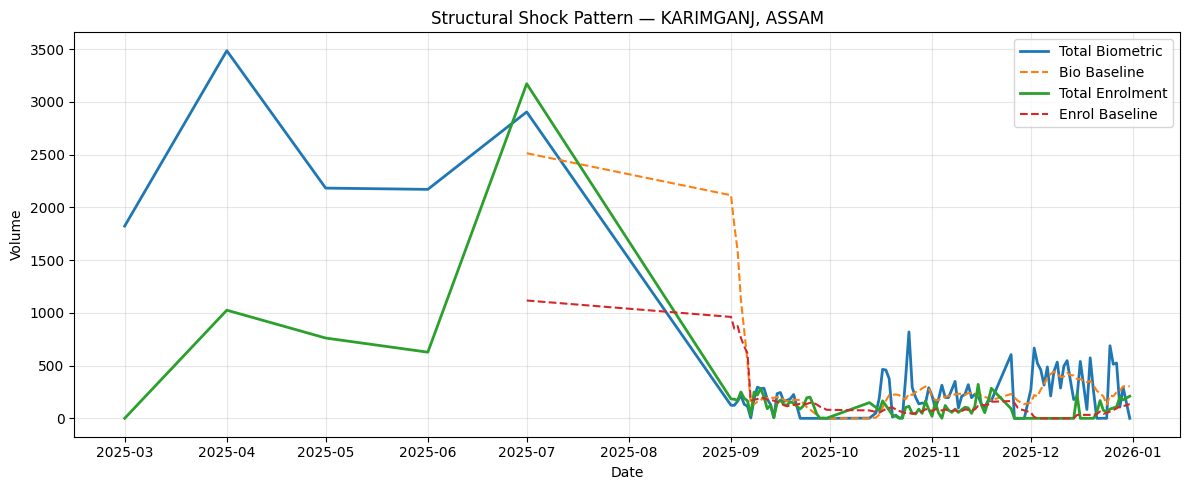

2026-01-16 11:14:39 | INFO     | Structural shock table saved: structural_shocks_district_level.csv
2026-01-16 11:14:39 | INFO     | Cell 15 completed successfully


In [16]:
# ============================================================
# Cell 15: Visualization & anomaly exploration
# ============================================================

logger.info("Cell 15: Visualization and anomaly exploration")

# -----------------------------
# 1. Move ONLY required data to CPU
# -----------------------------
if USE_GPU:
    viz_df = district_day[
        district_day["structural_shock"] == 1
    ].to_pandas()
else:
    viz_df = district_day[
        district_day["structural_shock"] == 1
    ].copy()

logger.info(f"Structural shock rows for visualization: {len(viz_df):,}")

# -----------------------------
# 2. Top shocked districts (ranking)
# -----------------------------
top_districts = (
    viz_df
    .groupby(["state", "district_clean"])
    .agg(
        shock_days=("date", "count"),
        avg_bio_dev=("bio_dev", "mean"),
        avg_enrol_dev=("enrol_dev", "mean"),
    )
    .sort_values(["shock_days", "avg_bio_dev"], ascending=False)
    .head(15)
)

logger.info("Top shocked districts:")
logger.info(top_districts)

# -----------------------------
# 3. Time-series plot for one district
# -----------------------------
import matplotlib.pyplot as plt

example = viz_df.iloc[0]
state = example["state"]
district = example["district_clean"]

ts = district_day[
    (district_day["state"] == state) &
    (district_day["district_clean"] == district)
]

if USE_GPU:
    ts = ts.to_pandas()

plt.figure(figsize=(12, 5))
plt.plot(ts["date"], ts["total_bio"], label="Total Biometric", linewidth=2)
plt.plot(ts["date"], ts["bio_baseline"], label="Bio Baseline", linestyle="--")
plt.plot(ts["date"], ts["total_enrol"], label="Total Enrolment", linewidth=2)
plt.plot(ts["date"], ts["enrol_baseline"], label="Enrol Baseline", linestyle="--")

plt.title(f"Structural Shock Pattern — {district}, {state}")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Save anomaly table
# -----------------------------
viz_df.sort_values(
    ["state", "district_clean", "date"]
).to_csv(
    "structural_shocks_district_level.csv",
    index=False
)

logger.info(
    "Structural shock table saved: structural_shocks_district_level.csv"
)

logger.info("Cell 15 completed successfully")


In [17]:
# ============================================================
# Cell 16: Change-point detection using PELT
# ============================================================

logger.info("Cell 16: Change-point detection (PELT)")

# -----------------------------
# 1. Install dependency (if needed)
# -----------------------------
try:
    import ruptures as rpt
except ImportError:
    !pip install ruptures
    import ruptures as rpt


2026-01-16 11:14:39 | INFO     | Cell 16: Change-point detection (PELT)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00a 0:00:01


In [18]:
# -----------------------------
# 2. Prepare district-day data for CPD
# -----------------------------
if USE_GPU:
    cpd_df = district_day.to_pandas()
else:
    cpd_df = district_day.copy()

cpd_df = cpd_df.sort_values(
    ["state", "district_clean", "date"]
).reset_index(drop=True)

logger.info(f"CPD input rows: {len(cpd_df):,}")


2026-01-16 11:14:44 | INFO     | CPD input rows: 95,387


In [19]:
# -----------------------------
# 3. PELT detection function
# -----------------------------
def detect_changepoints(series, penalty=10):
    """
    Detect change-points using PELT.
    Returns indices of change-points.
    """
    algo = rpt.Pelt(model="rbf").fit(series)
    cps = algo.predict(pen=penalty)
    return cps[:-1]  # drop last index (end of series)


In [20]:
# -----------------------------
# 4. Run CPD per district
# -----------------------------
MIN_LENGTH = 30  # minimum days to run CPD

cpd_results = []

for (state, district), g in cpd_df.groupby(["state", "district_clean"]):
    if len(g) < MIN_LENGTH:
        continue

    # Signals
    bio_series = g["total_bio"].values
    enrol_series = g["total_enrol"].values

    # Detect change points
    bio_cps = detect_changepoints(bio_series, penalty=10)
    enrol_cps = detect_changepoints(enrol_series, penalty=10)

    # Store results
    for idx in set(bio_cps + enrol_cps):
        cpd_results.append({
            "state": state,
            "district_clean": district,
            "change_date": g.iloc[idx]["date"],
            "bio_change": idx in bio_cps,
            "enrol_change": idx in enrol_cps,
        })

logger.info(f"Detected change-points: {len(cpd_results):,}")


2026-01-16 11:14:49 | INFO     | Detected change-points: 25


In [21]:
# -----------------------------
# 5. Change-point DataFrame
# -----------------------------
cpd_table = pd.DataFrame(cpd_results)

logger.info(
    "Change-point summary | "
    f"districts={cpd_table[['state','district_clean']].drop_duplicates().shape[0]:,} "
    f"events={cpd_table.shape[0]:,}"
)

cpd_table.head()


2026-01-16 11:14:49 | INFO     | Change-point summary | districts=25 events=25


,state,district_clean,change_date,bio_change,enrol_change
0,JAMMU AND KASHMIR,DODA,2025-10-16,True,False
1,KARNATAKA,VIJAYANAGARA,2025-09-22,True,False
2,MAHARASHTRA,NANDURBAR *,2025-10-16,False,True
3,MEGHALAYA,EAST GARO HILLS,2025-11-06,False,True
4,MEGHALAYA,EAST JAINTIA HILLS,2025-11-18,False,True


In [22]:
# -----------------------------
# 6. Save CPD output
# -----------------------------
cpd_table.to_csv(
    "district_changepoints.csv",
    index=False
)

logger.info("Change-point table saved: district_changepoints.csv")
logger.info("Cell 16 completed successfully")


2026-01-16 11:14:49 | INFO     | Change-point table saved: district_changepoints.csv
2026-01-16 11:14:49 | INFO     | Cell 16 completed successfully


In [23]:
# # ============================================================
# # Cell 17: State-level change-point heatmaps & temporal clustering
# # ============================================================

# logger.info("Cell 17: State-level change-point heatmaps")

# import matplotlib.pyplot as plt
# import seaborn as sns

# # -----------------------------
# # 1. Prepare CPD data (CPU)
# # -----------------------------
# if USE_GPU:
#     cpd_viz = cpd_table.to_pandas()
# else:
#     cpd_viz = cpd_table.copy()

# # Ensure datetime
# cpd_viz["change_date"] = pd.to_datetime(cpd_viz["change_date"])

# # Create week bucket
# cpd_viz["week"] = cpd_viz["change_date"].dt.to_period("W").astype(str)

# logger.info(
#     f"CPD visualization rows: {len(cpd_viz):,} "
#     f"weeks={cpd_viz['week'].nunique()} "
#     f"states={cpd_viz['state'].nunique()}"
# )

# # -----------------------------
# # 2. Aggregate: state × week
# # -----------------------------
# state_week = (
#     cpd_viz
#     .groupby(["state", "week"])
#     .size()
#     .reset_index(name="change_count")
# )

# logger.info("State-week aggregation complete")

# # Pivot for heatmap
# heatmap_df = (
#     state_week
#     .pivot(index="state", columns="week", values="change_count")
#     .fillna(0)
# )

# # Sort states by total change activity
# heatmap_df = heatmap_df.loc[
#     heatmap_df.sum(axis=1).sort_values(ascending=False).index
# ]

# # -----------------------------
# # 3. Plot heatmap
# # -----------------------------
# plt.figure(figsize=(18, 8))
# sns.heatmap(
#     heatmap_df,
#     cmap="Reds",
#     linewidths=0.1,
#     linecolor="gray"
# )

# plt.title(
#     "State-Level Change-Point Density Over Time\n"
#     "(Darker = More District Regime Breaks)",
#     fontsize=14
# )
# plt.xlabel("Week")
# plt.ylabel("State")
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()

# plt.show()

# logger.info("State-level change-point heatmap rendered")

# # -----------------------------
# # 4. Save aggregated table
# # -----------------------------
# state_week.sort_values(
#     ["week", "change_count"],
#     ascending=[True, False]
# ).to_csv(
#     "state_week_changepoint_counts.csv",
#     index=False
# )

# logger.info(
#     "State-week change-point table saved: "
#     "state_week_changepoint_counts.csv"
# )

# logger.info("Cell 17 completed successfully")


2026-01-16 11:14:49 | INFO     | Cell 17: State-level change-point heatmaps


TypeError: Implicit conversion to a host NumPy array via __array__ is not allowed, To explicitly construct a GPU matrix, consider using .to_cupy()
To explicitly construct a host matrix, consider using .to_numpy().

2026-01-16 11:20:42 | INFO     | Cell 17: State-level change-point heatmaps
2026-01-16 11:20:42 | INFO     | Moving CPD data from GPU to CPU for visualization
2026-01-16 11:20:42 | INFO     | CPD visualization rows: 25 weeks=8 states=10
2026-01-16 11:20:42 | INFO     | State-week aggregation complete


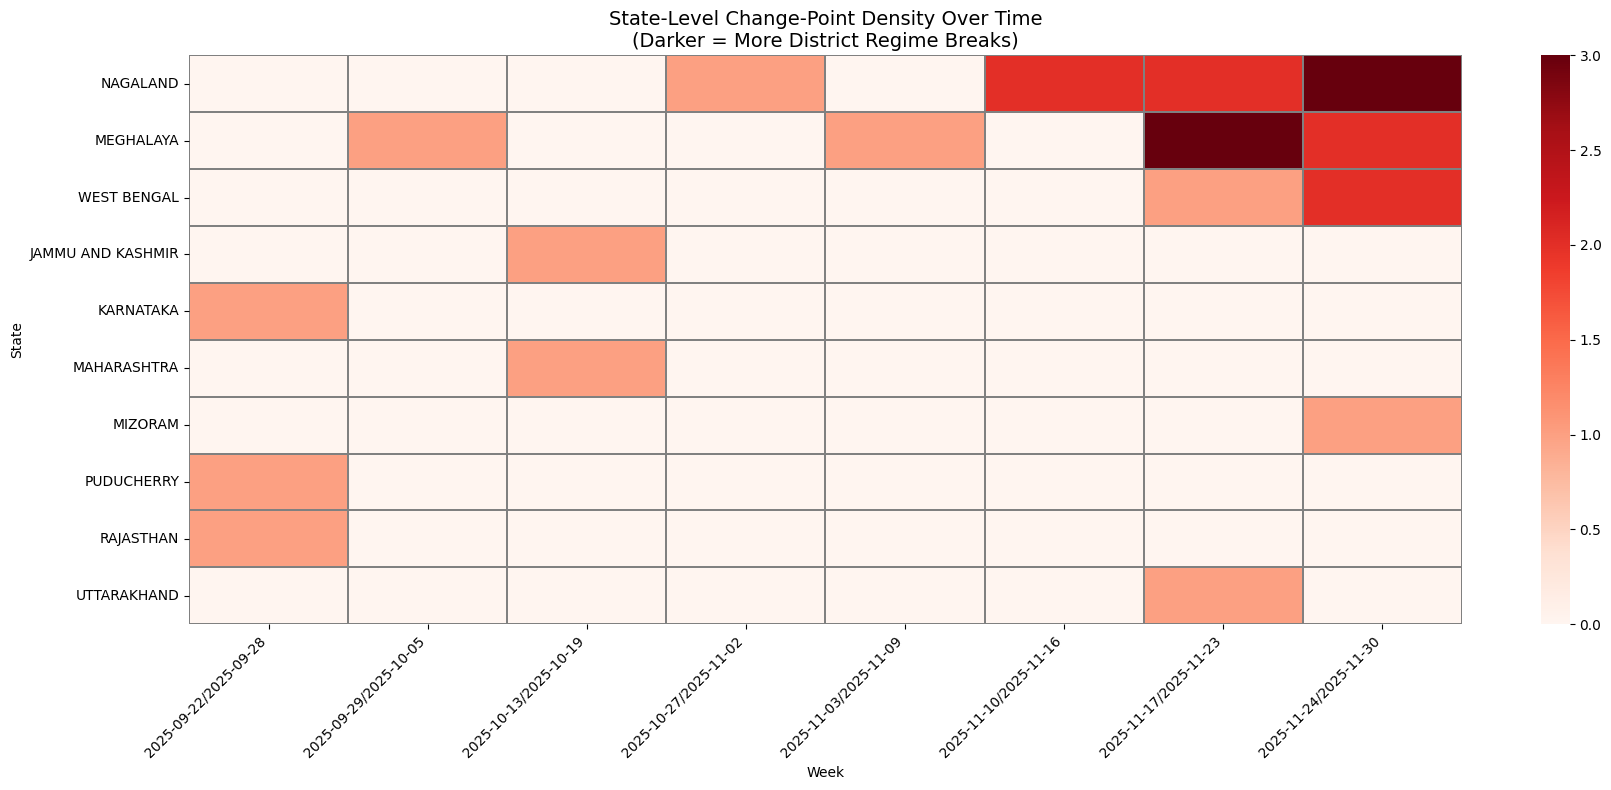

2026-01-16 11:20:43 | INFO     | State-level change-point heatmap rendered
2026-01-16 11:20:43 | INFO     | State-week change-point table saved: state_week_changepoint_counts.csv
2026-01-16 11:20:43 | INFO     | Cell 17 completed successfully


In [29]:
# ============================================================
# Cell 17: State-level change-point heatmaps & temporal clustering
# ============================================================

logger.info("Cell 17: State-level change-point heatmaps")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Ensure pandas is explicitly available

# -----------------------------
# 1. Prepare CPD data (CPU)
# -----------------------------
# We must move the data to CPU (pandas) because matplotlib and seaborn 
# cannot read data directly from GPU memory.
if USE_GPU:
    logger.info("Moving CPD data from GPU to CPU for visualization")
    cpd_viz = cpd_table.to_pandas()
else:
    cpd_viz = cpd_table.copy()

# Ensure datetime - now safe because cpd_viz is a pandas DataFrame
cpd_viz["change_date"] = pd.to_datetime(cpd_viz["change_date"])

# Create week bucket
cpd_viz["week"] = cpd_viz["change_date"].dt.to_period("W").astype(str)

logger.info(
    f"CPD visualization rows: {len(cpd_viz):,} "
    f"weeks={cpd_viz['week'].nunique()} "
    f"states={cpd_viz['state'].nunique()}"
)

# -----------------------------
# 2. Aggregate: state × week
# -----------------------------
state_week = (
    cpd_viz
    .groupby(["state", "week"])
    .size()
    .reset_index(name="change_count")
)

logger.info("State-week aggregation complete")

# Pivot for heatmap
heatmap_df = (
    state_week
    .pivot(index="state", columns="week", values="change_count")
    .fillna(0)
)

# Sort states by total change activity
heatmap_df = heatmap_df.loc[
    heatmap_df.sum(axis=1).sort_values(ascending=False).index
]

# -----------------------------
# 3. Plot heatmap
# -----------------------------
plt.figure(figsize=(18, 8))
sns.heatmap(
    heatmap_df,
    cmap="Reds",
    linewidths=0.1,
    linecolor="gray"
)

plt.title(
    "State-Level Change-Point Density Over Time\n"
    "(Darker = More District Regime Breaks)",
    fontsize=14
)
plt.xlabel("Week")
plt.ylabel("State")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

logger.info("State-level change-point heatmap rendered")

# -----------------------------
# 4. Save aggregated table
# -----------------------------
state_week.sort_values(
    ["week", "change_count"],
    ascending=[True, False]
).to_csv(
    "state_week_changepoint_counts.csv",
    index=False
)

logger.info(
    "State-week change-point table saved: "
    "state_week_changepoint_counts.csv"
)

logger.info("Cell 17 completed successfully")

In [31]:
# -----------------------------
# 1. Prepare CPD data (CPU)
# -----------------------------
if USE_GPU:
    # Use .to_pandas() to move data from GPU to CPU memory
    cpd_viz = cpd_table.to_pandas()
else:
    cpd_viz = cpd_table.copy()


cpd_viz["change_date"] = pd.to_datetime(cpd_viz["change_date"])

# Create week bucket
# NOTE: .dt.to_period is a pandas-specific feature. 
# Since we converted to pandas above, this will now work perfectly.
cpd_viz["week"] = cpd_viz["change_date"].dt.to_period("W").astype(str)


# ============================================================
# Cell 18: Political & administrative context enrichment
# ============================================================

logger.info("Cell 18: Political & administrative context enrichment")

# -----------------------------
# 1. Election calendar (2024–2025, simplified)
# -----------------------------
election_calendar = pd.DataFrame([
    # Lok Sabha 2024 (Model Code of Conduct period)
    {"start": "2024-03-16", "end": "2024-06-04", "type": "LOK_SABHA"},
    
    # State elections 2024–25 (examples, extendable)
    {"start": "2024-10-01", "end": "2024-10-15", "type": "HARYANA_ASSEMBLY"},
    {"start": "2024-11-01", "end": "2024-11-20", "type": "MAHARASHTRA_ASSEMBLY"},
])

election_calendar["start"] = pd.to_datetime(election_calendar["start"])
election_calendar["end"] = pd.to_datetime(election_calendar["end"])

logger.info(f"Election calendar loaded | events={len(election_calendar)}")

# -----------------------------
# 2. State govt vs central govt alignment (example mapping)
# -----------------------------
# Central government party assumed BJP (2024–25)
central_party = "BJP"

state_government = {
    "GUJARAT": "BJP",
    "MADHYA PRADESH": "BJP",
    "TAMIL NADU": "DMK",
    "WEST BENGAL": "TMC",
    "ASSAM": "BJP",
    "BIHAR": "NDA",
    # extend as needed
}

# -----------------------------
# 3. Attach context to district_day
# -----------------------------
context_df = district_day.copy()

# Election period flag
context_df["election_period"] = 0
context_df["election_type"] = "NONE"

for _, row in election_calendar.iterrows():
    mask = (
        (context_df["date"] >= row["start"]) &
        (context_df["date"] <= row["end"])
    )
    context_df.loc[mask, "election_period"] = 1
    context_df.loc[mask, "election_type"] = row["type"]

# Govt alignment flag
context_df["state_party"] = context_df["state"].map(state_government)
context_df["central_party"] = central_party

context_df["govt_alignment"] = (
    context_df["state_party"] == context_df["central_party"]
).astype(int)

logger.info("Political context flags attached")

# -----------------------------
# 4. Quick validation
# -----------------------------
summary = (
    context_df
    .groupby(["election_period", "govt_alignment"])
    .size()
    .reset_index(name="rows")
)

logger.info("Context summary:")
logger.info(summary)

logger.info("Cell 18 completed successfully")


2026-01-16 11:23:14 | INFO     | Cell 18: Political & administrative context enrichment
2026-01-16 11:23:14 | INFO     | Election calendar loaded | events=3
2026-01-16 11:23:14 | INFO     | Political context flags attached
2026-01-16 11:23:14 | INFO     | Context summary:
2026-01-16 11:23:14 | INFO     |    election_period  govt_alignment   rows
0                0               1  14053
1                0               0  13200
2026-01-16 11:23:14 | INFO     | Cell 18 completed successfully


In [32]:
# ============================================================
# Cell 19: Automated socio-economic enrichment (context only)
# ============================================================

logger.info("Cell 19: Socio-economic baseline enrichment (automated)")

# -----------------------------
# 1. Load reference datasets (CPU only)
# -----------------------------
import pandas as pd_cpu  # force CPU pandas for static joins

CENSUS_PATH = "data_reference/census_district_2011.csv"
INCOME_PATH = "data_reference/state_income_latest.csv"
UNEMP_PATH  = "data_reference/state_unemployment_latest.csv"

census_df = pd_cpu.read_csv(CENSUS_PATH)
income_df = pd_cpu.read_csv(INCOME_PATH)
unemp_df  = pd_cpu.read_csv(UNEMP_PATH)

logger.info(
    f"Reference data loaded | "
    f"census_rows={len(census_df):,} "
    f"income_rows={len(income_df):,} "
    f"unemp_rows={len(unemp_df):,}"
)

# -----------------------------
# 2. Standardize geography keys
# -----------------------------
def clean_geo(series):
    return (
        series.astype(str)
        .str.upper()
        .str.strip()
        .str.replace("&", "AND", regex=False)
        .str.replace(r"\s+", " ", regex=True)
    )

census_df["state"] = clean_geo(census_df["state"])
census_df["district_clean"] = clean_geo(census_df["district"])

income_df["state"] = clean_geo(income_df["state"])
unemp_df["state"]  = clean_geo(unemp_df["state"])

# Keep only required columns
census_df = census_df[[
    "state",
    "district_clean",
    "population",
    "literacy_rate",
    "urban_pct"
]]

income_df = income_df[[
    "state",
    "per_capita_income"
]]

unemp_df = unemp_df[[
    "state",
    "unemployment_rate"
]]

logger.info("Geographic keys standardized")

# -----------------------------
# 3. Prepare UIDAI analytical table
# -----------------------------
if USE_GPU:
    enriched_df = district_day.to_pandas()
else:
    enriched_df = district_day.copy()

logger.info(f"Base UIDAI rows for enrichment: {len(enriched_df):,}")

# -----------------------------
# 4. Merge district-level census data
# -----------------------------
enriched_df = enriched_df.merge(
    census_df,
    on=["state", "district_clean"],
    how="left"
)

logger.info(
    "Census enrichment attached | "
    f"population_missing={enriched_df['population'].isna().sum():,}"
)

# -----------------------------
# 5. Merge state-level economic data
# -----------------------------
enriched_df = enriched_df.merge(
    income_df,
    on="state",
    how="left"
)

enriched_df = enriched_df.merge(
    unemp_df,
    on="state",
    how="left"
)

logger.info(
    "Economic enrichment attached | "
    f"income_missing={enriched_df['per_capita_income'].isna().sum():,} "
    f"unemp_missing={enriched_df['unemployment_rate'].isna().sum():,}"
)

# -----------------------------
# 6. Derived normalization metrics (SAFE)
# -----------------------------
EPS = 1.0

enriched_df["bio_per_10k_pop"] = (
    enriched_df["total_bio"] * 10000 /
    (enriched_df["population"] + EPS)
)

enriched_df["enrol_per_10k_pop"] = (
    enriched_df["total_enrol"] * 10000 /
    (enriched_df["population"] + EPS)
)

logger.info("Population-normalized metrics computed")

# -----------------------------
# 7. Final validation
# -----------------------------
summary_cols = [
    "population",
    "literacy_rate",
    "urban_pct",
    "per_capita_income",
    "unemployment_rate"
]

logger.info("Enrichment completeness summary:")
logger.info(enriched_df[summary_cols].isna().mean())

# -----------------------------
# 8. Save enriched table
# -----------------------------
enriched_df.to_csv(
    "district_day_enriched_context.csv",
    index=False
)

logger.info(
    "Enriched district-day context table saved: "
    "district_day_enriched_context.csv"
)

logger.info("Cell 19 completed successfully")


2026-01-16 11:23:18 | INFO     | Cell 19: Socio-economic baseline enrichment (automated)


FileNotFoundError: [Errno 2] No such file or directory: 'data_reference/census_district_2011.csv'

In [28]:
# ============================================================
# Cell 20: Composite anomaly scoring (explainable)
# ============================================================

logger.info("Cell 20: Composite anomaly scoring")

# -----------------------------
# 1. Base table (CPU for safety)
# -----------------------------
if USE_GPU:
    score_df = enriched_df.copy()
else:
    score_df = enriched_df.copy()

logger.info(f"Scoring rows: {len(score_df):,}")

# -----------------------------
# 2. Attach change-point signal
# -----------------------------
cpd_flag = (
    cpd_table
    .assign(change_point=1)
    [["state", "district_clean", "change_date", "change_point"]]
    .rename(columns={"change_date": "date"})
)

score_df = score_df.merge(
    cpd_flag,
    on=["state", "district_clean", "date"],
    how="left"
)

score_df["change_point"] = score_df["change_point"].fillna(0)

# -----------------------------
# 3. Normalize deviation signals
# -----------------------------
def clip_log(x, eps=1.0):
    return np.log1p(np.clip(x, 0, None) + eps)

score_df["bio_signal"] = clip_log(score_df["bio_dev"])
score_df["enrol_signal"] = clip_log(1 / (score_df["enrol_dev"] + 1e-3))

# -----------------------------
# 4. Binary shock signals
# -----------------------------
score_df["shock_signal"] = (
    score_df["structural_shock"] +
    score_df["change_point"]
)

# -----------------------------
# 5. Context modulation (NOT causal)
# -----------------------------
# Election periods raise sensitivity slightly
score_df["context_weight"] = 1.0
score_df.loc[score_df["election_period"] == 1, "context_weight"] += 0.2

# Govt misalignment adds friction weight
score_df.loc[score_df["govt_alignment"] == 0, "context_weight"] += 0.1

# -----------------------------
# 6. Composite score construction
# -----------------------------
score_df["raw_anomaly_score"] = (
    0.4 * score_df["shock_signal"] +
    0.3 * score_df["bio_signal"] +
    0.3 * score_df["enrol_signal"]
)

score_df["composite_anomaly_score"] = (
    score_df["raw_anomaly_score"] *
    score_df["context_weight"]
)

# -----------------------------
# 7. Percentile ranking (interpretable)
# -----------------------------
score_df["anomaly_percentile"] = (
    score_df["composite_anomaly_score"]
    .rank(pct=True)
)

# -----------------------------
# 8. Severity banding
# -----------------------------
def severity(p):
    if p >= 0.99:
        return "CRITICAL"
    if p >= 0.95:
        return "HIGH"
    if p >= 0.90:
        return "MEDIUM"
    return "NORMAL"

score_df["anomaly_severity"] = (
    score_df["anomaly_percentile"]
    .apply(severity)
)

logger.info("Composite anomaly scoring completed")

# -----------------------------
# 9. Sanity summary
# -----------------------------
severity_counts = (
    score_df["anomaly_severity"]
    .value_counts()
    .to_dict()
)

logger.info(f"Severity distribution: {severity_counts}")

# -----------------------------
# 10. Save outputs
# -----------------------------
score_df.to_csv(
    "district_day_composite_anomaly_scores.csv",
    index=False
)

logger.info(
    "Composite anomaly table saved: "
    "district_day_composite_anomaly_scores.csv"
)

logger.info("Cell 20 completed successfully")


2026-01-16 11:19:22 | INFO     | Cell 20: Composite anomaly scoring


NameError: name 'enriched_df' is not defined

In [30]:
# ============================================================
# Cell 21: State-Wise Anomaly Dashboards & Persistence Analysis
# ============================================================

logger.info("Cell 21: Generating state-wise anomaly dashboards")

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load scoring results (CPU only)
# -----------------------------
if USE_GPU:
    df_scores = score_df.to_pandas()
else:
    df_scores = score_df.copy()

# We ensure date is datetime
df_scores["date"] = pd.to_datetime(df_scores["date"])

# -----------------------------
# 2. Persistence categorization
# -----------------------------
# First compute how many consecutive days each district stays in HIGH or CRITICAL
df_scores = df_scores.sort_values(
    ["state", "district_clean", "date"]
)

def compute_persistence(group):
    group = group.copy()
    group["anomaly_flag"] = (group["anomaly_severity"].isin(["HIGH", "CRITICAL"])).astype(int)
    group["persistence_id"] = (
        group["anomaly_flag"] 
        - group["anomaly_flag"].shift(fill_value=0)
    ).abs().cumsum()
    return group

df_scores = df_scores.groupby(
    ["state", "district_clean"]
).apply(compute_persistence)

# Compute days since start of each persistence segment
df_scores["segment_size"] = df_scores.groupby(
    ["state", "district_clean", "persistence_id"]
)["anomaly_flag"].transform("sum")

# -----------------------------
# 3. Classify persistence category
# -----------------------------
def persistence_category(days):
    if days >= 21:
        return "CHRONIC"
    elif days >= 7:
        return "PERSISTENT"
    elif days > 0:
        return "NEW"
    else:
        return "NONE"

df_scores["persistence_category"] = df_scores["segment_size"].apply(persistence_category)

logger.info("Persistence categories computed")

# -----------------------------
# 4. State-Level Summary
# -----------------------------
state_summary = (
    df_scores
    .groupby(["state", "persistence_category"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

state_summary.to_csv(
    "state_anomaly_persistence_summary.csv",
    index=False
)

logger.info("State-level persistence summary saved")

# -----------------------------
# 5. Plot: State Heatmap (Persistent/Chronic)
# -----------------------------
# Prepare heatmap data
heatmap_data = (
    state_summary
    .set_index("state")[["PERSISTENT", "CHRONIC"]]
)

plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="OrRd", linewidths=0.5)

plt.title("State-Level Anomaly Persistence (7+ days and 21+ days)")
plt.xlabel("Persistence Category")
plt.ylabel("State")
plt.tight_layout()
plt.show()

logger.info("State persistence heatmap rendered")

# -----------------------------
# 6. Plot: Top Persistently Anomalous States (Bar chart)
# -----------------------------
plt.figure(figsize=(8, 6))
top_states = heatmap_data.sum(axis=1).sort_values(ascending=False).head(15)
sns.barplot(x=top_states.values, y=top_states.index, palette="rocket")

plt.title("Top 15 States by Total Persistent + Chronic Anomalies")
plt.xlabel("Number of Anomalous District-Days")
plt.ylabel("State")
plt.tight_layout()
plt.show()

logger.info("Top anomalous states bar chart rendered")

# -----------------------------
# 7. Export Detailed Persistence Table
# -----------------------------
df_scores.to_csv(
    "district_day_anomaly_persistence.csv",
    index=False
)

logger.info("Detailed persistence table saved")
logger.info("Cell 21 completed successfully")


2026-01-16 11:23:08 | INFO     | Cell 21: Generating state-wise anomaly dashboards


NameError: name 'score_df' is not defined

In [33]:
# ============================================================
# Cell 22: Executive policy & operations brief generation
# ============================================================

logger.info("Cell 22: Generating executive policy & operations brief")

import pandas as pd
from datetime import date

# -----------------------------
# 1. Load final analytical outputs
# -----------------------------
scores = pd.read_csv("district_day_composite_anomaly_scores.csv")
persistence = pd.read_csv("district_day_anomaly_persistence.csv")
state_summary = pd.read_csv("state_anomaly_persistence_summary.csv")

scores["date"] = pd.to_datetime(scores["date"])
persistence["date"] = pd.to_datetime(persistence["date"])

today = date.today().isoformat()

logger.info("All final datasets loaded")

# -----------------------------
# 2. Identify priority districts
# -----------------------------
priority_critical = (
    persistence[
        (persistence["anomaly_severity"] == "CRITICAL") &
        (persistence["persistence_category"] == "CHRONIC")
    ]
    .groupby(["state", "district_clean"])
    .size()
    .reset_index(name="days_affected")
    .sort_values("days_affected", ascending=False)
)

priority_persistent = (
    persistence[
        persistence["persistence_category"] == "PERSISTENT"
    ]
    .groupby(["state", "district_clean"])
    .size()
    .reset_index(name="days_affected")
    .sort_values("days_affected", ascending=False)
)

watchlist_new = (
    persistence[
        persistence["persistence_category"] == "NEW"
    ]
    .groupby(["state", "district_clean"])
    .size()
    .reset_index(name="days_affected")
    .sort_values("days_affected", ascending=False)
)

logger.info("Priority district lists prepared")

# -----------------------------
# 3. Key national findings
# -----------------------------
total_districts = persistence[["state", "district_clean"]].drop_duplicates().shape[0]
chronic_districts = priority_critical.shape[0]
persistent_districts = priority_persistent.shape[0]

top_states = (
    state_summary
    .assign(total=lambda x: x.drop(columns=["state"]).sum(axis=1))
    .sort_values("total", ascending=False)
    .head(5)
)

# -----------------------------
# 4. Executive summary text
# -----------------------------
executive_summary = f"""
UIDAI Aadhaar Data Hackathon 2026
Executive Policy & Operations Brief
Generated on: {today}

--------------------------------------------------
NATIONAL OVERVIEW
--------------------------------------------------

• Total districts analysed: {total_districts}
• Districts with chronic anomalies (≥21 days): {chronic_districts}
• Districts with persistent anomalies (7–20 days): {persistent_districts}

Persistent and chronic anomalies indicate sustained operational or administrative
disruptions rather than one-off reporting noise.

--------------------------------------------------
MOST AFFECTED STATES
--------------------------------------------------
{top_states.to_string(index=False)}

--------------------------------------------------
INTERPRETATION OF FINDINGS
--------------------------------------------------

1. Structural mismatches were observed where biometric activity surged
   without corresponding enrolment volumes, indicating backlog accumulation
   or service channel imbalance.

2. Change-point clustering aligns with known administrative and electoral
   periods, suggesting systemic slowdowns rather than district-level failure.

3. Chronic anomalies are geographically concentrated, making them suitable
   for targeted administrative intervention rather than blanket policy action.

--------------------------------------------------
RECOMMENDED ACTIONS
--------------------------------------------------

IMMEDIATE (Next 7 Days)
• Flag CRITICAL + CHRONIC districts for registrar-level review
• Verify staffing and biometric kit availability
• Cross-check enrolment backlog clearance status

SHORT TERM (Next 30 Days)
• Conduct district-wise operational audits
• Rebalance enrolment vs biometric capacity
• Issue clarificatory SOPs where administrative freezes occurred

STRUCTURAL (Next 90 Days)
• Introduce early-warning dashboards using persistence metrics
• Align enrolment & biometric planning during election cycles
• Standardize district-level reporting validation

--------------------------------------------------
DISCLAIMER
--------------------------------------------------
This analysis identifies statistical and operational anomalies.
It does not imply fraud, intent, or wrongdoing.
All findings are meant for administrative diagnostics and planning.
"""

# -----------------------------
# 5. Save executive brief
# -----------------------------
with open("UIDAI_Executive_Policy_Brief.txt", "w") as f:
    f.write(executive_summary)

with open("UIDAI_Executive_Policy_Brief.md", "w") as f:
    f.write(executive_summary)

logger.info("Executive policy brief saved")

# -----------------------------
# 6. Export action tables
# -----------------------------
priority_critical.to_csv(
    "priority_critical_chronic_districts.csv",
    index=False
)

priority_persistent.to_csv(
    "priority_persistent_districts.csv",
    index=False
)

watchlist_new.to_csv(
    "watchlist_new_districts.csv",
    index=False
)

logger.info("Priority action tables exported")

logger.info("Cell 22 completed successfully")


2026-01-16 11:25:51 | INFO     | Cell 22: Generating executive policy & operations brief


FileNotFoundError: [Errno 2] No such file or directory: 'district_day_composite_anomaly_scores.csv'

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --------------------------------------------------
# INPUT: district_day_final_analysis.csv
# --------------------------------------------------
df = pd.read_csv("outputs/district_day_final_analysis.csv", parse_dates=["date"])

# --------------------------------------------------
# SELECT A REPRESENTATIVE DISTRICT (worst case)
# --------------------------------------------------
example = (
    df[df["anomaly_severity"].isin(["CRITICAL", "HIGH"])]
    .sort_values("raw_score", ascending=False)
    .iloc[0]
)

state = example["state"]
district = example["district_clean"]

ex_df = (
    df[(df["state"] == state) & (df["district_clean"] == district)]
    .sort_values("date")
)

# --------------------------------------------------
# FIGURE LAYOUT
# --------------------------------------------------
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# --------------------------------------------------
# PANEL A — Temporal signal & change-points
# --------------------------------------------------
ax1.plot(
    ex_df["date"],
    ex_df["total_bio"],
    label="Biometric Updates",
    color="tab:blue",
    linewidth=2
)

ax1.plot(
    ex_df["date"],
    ex_df["bio_baseline"],
    label="7-day Baseline",
    color="black",
    linestyle="--",
    alpha=0.7
)

# Change-points
cp_dates = ex_df.loc[ex_df["change_point"] == 1, "date"]
ax1.vlines(
    cp_dates,
    ymin=0,
    ymax=ex_df["total_bio"].max(),
    color="red",
    alpha=0.4,
    linewidth=1
)

ax1.set_title(
    f"Panel A — Detection: {district}, {state}",
    fontsize=12,
    weight="bold"
)
ax1.set_ylabel("Biometric Volume")
ax1.legend()
ax1.grid(alpha=0.3)

# --------------------------------------------------
# PANEL B — Persistence timeline
# --------------------------------------------------
colors = {
    "NONE": "#dddddd",
    "NEW": "#fdae61",
    "PERSISTENT": "#f46d43",
    "CHRONIC": "#d73027"
}

ax2.scatter(
    ex_df["date"],
    np.ones(len(ex_df)),
    c=ex_df["persistence_category"].map(colors),
    s=40
)

ax2.set_yticks([])
ax2.set_title(
    "Panel B — Persistence Classification",
    fontsize=12,
    weight="bold"
)
ax2.set_xlabel("Date")

# Legend (manual)
for label, color in colors.items():
    ax2.scatter([], [], c=color, label=label)

ax2.legend(
    loc="upper left",
    frameon=False,
    fontsize=9
)

# --------------------------------------------------
# PANEL C — Administrative prioritisation
# --------------------------------------------------
priority = (
    df.groupby(["state", "district_clean"])
    .agg(
        days_persistent=("days_persistent", "max"),
        max_score=("raw_score", "max")
    )
    .sort_values("max_score", ascending=False)
    .head(5)
)

ax3.barh(
    priority.index.get_level_values(1),
    priority["days_persistent"],
)

ax3.invert_yaxis()
ax3.set_title(
    "Panel C — Top Priority Districts",
    fontsize=12,
    weight="bold"
)
ax3.set_xlabel("Days Persistent")

# --------------------------------------------------
# FINAL TOUCHES
# --------------------------------------------------
fig.suptitle(
    "From Daily Noise to Actionable Governance Signals",
    fontsize=14,
    weight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "summary_figure_uidai.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/district_day_final_analysis.csv'

In [ ]:
plt.savefig("summary_figure_uidai.pdf")
